# I confirm that this is my own work, except where clearly indicated.

Note: All Data was accumulated on and accurate as of May 5th

Importing Packages

In [256]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt

In [257]:
input_data = pd.read_csv("train.csv")

In [258]:
input_data['Date'] =  pd.to_datetime(input_data['Date'])

In [259]:
input_data = input_data.drop("Id", axis=1)

Copy the training data, for manipulation purposes

In [260]:
manipulated_data = input_data.copy()

The objective is to only have one column to represent one location, thus the country/region and province/state columns would be merged. There is a conflict in the name for the country and the state of Georgia, thus to differentiate, a "_c" was added to all of the countries to differentiate

In [261]:
manipulated_data["Country_Region"] = manipulated_data["Country_Region"] + "_C"

Have one column by merging the country into thhe province data, i.e. replace all NANs in the province column with the corresponding column

In [262]:
manipulated_data.Province_State.fillna(manipulated_data.Country_Region, inplace=True)

Remove second column for location, and then rename the columns

In [263]:
manipulated_data.drop("Country_Region", axis=1, inplace=True)

In [264]:
manipulated_data.columns = ['Location', 'Date', 'ConfirmedCases','Fatalities']

In [349]:
manipulated_data

,Location,Date,ConfirmedCases,Fatalities
0,Afghanistan_C,2020-01-22,0.0,0.0
1,Afghanistan_C,2020-01-23,0.0,0.0
2,Afghanistan_C,2020-01-24,0.0,0.0
3,Afghanistan_C,2020-01-25,0.0,0.0
4,Afghanistan_C,2020-01-26,0.0,0.0
...,...,...,...,...
20575,Zimbabwe_C,2020-03-27,5.0,1.0
20576,Zimbabwe_C,2020-03-28,7.0,1.0
20577,Zimbabwe_C,2020-03-29,7.0,1.0
20578,Zimbabwe_C,2020-03-30,7.0,1.0


plots

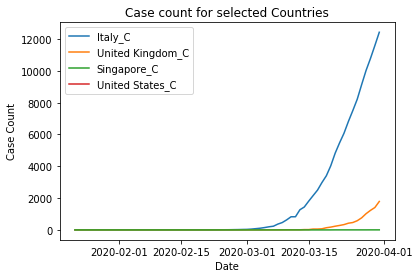

In [266]:
list_of_countries=["Italy_C", "United Kingdom_C","Singapore_C","United States_C"]

for i in list_of_countries:
    plt.plot(manipulated_data[manipulated_data["Location"] == i]["Date"], 
            manipulated_data[manipulated_data["Location"] == i]["Fatalities"], 
            label=i)
plt.xlabel('Date')
plt.ylabel('Case Count')

plt.title('Case count for selected Countries')
plt.legend()
plt.show()



Since there is a large amount of data manipulation and merging, the prediction set will be manipulated and merged at the same time as the training data,

In [267]:
prediction_test_data = pd.read_csv("test.csv")
prediction_test_data['Date'] =  pd.to_datetime(prediction_test_data['Date'])
forecast_ids = prediction_test_data["ForecastId"]
prediction_test_data.drop("ForecastId", axis=1, inplace=True)
prediction_test_data["Country_Region"] = prediction_test_data["Country_Region"] + "_C"
prediction_test_data.Province_State.fillna(prediction_test_data.Country_Region, inplace=True)
prediction_test_data.drop("Country_Region", axis=1, inplace=True)
prediction_test_data.columns = ['Location', 'Date']

### Lockdown Dates

The first dataset which will be merged is a list of lockdown dates and types for each location on the province, this is added as this is seen as a crucial factor in predicting both cases and fatalities.

In [268]:
lockdown_dates = pd.read_csv("countryLockdownDates.csv")

In [269]:
lockdown_dates = lockdown_dates.drop("Reference", axis=1)

The same "\_C" transformation and column merging occurs so that merging datasets can happen easily 

In [270]:
lockdown_dates["Country/Region"] = lockdown_dates["Country/Region"] + "_C"

In [271]:
lockdown_dates.Province.fillna(lockdown_dates["Country/Region"], inplace=True)

In [272]:
lockdown_dates.drop("Country/Region", axis =1, inplace=True)

In [273]:
lockdown_dates

,Province,Date,Type
0,Afghanistan_C,24/03/2020,Full
1,Albania_C,08/03/2020,Full
2,Algeria_C,24/03/2020,Full
3,Andorra_C,16/03/2020,Full
4,Angola_C,24/03/2020,Full
...,...,...,...
302,Venezuela_C,16/03/2020,Full
303,Vietnam_C,19/03/2020,Full
304,West Bank and Gaza_C,05/03/2020,Full
305,Zambia_C,NaN,None


Map the lockdown types to be ordinal, 0 represents no lockdown, 1 - Partial, and 2 - full

In [274]:
lockdown_map = {'None':0, 'Partial':1, 'Full':2}

lockdown_dates.Type = lockdown_dates.Type.apply(lambda x: lockdown_map.get(x))

If there isn't any lockdown information given, it is replaced with 0, as in this case is it safe to assume there wouldn't be countrywide lockdowns

In [275]:
lockdown_dates.Date.fillna(0, inplace=True)

In [276]:
lockdown_dates.columns = ['Location', 'Lockdown_Date', 'Lockdown_Type']

Peform an SQL style "left" join on the data

In [277]:
merged = pd.merge(manipulated_data, lockdown_dates, on='Location', how="left")

In [278]:
merged["Lockdown_Date"] = pd.to_datetime(merged['Lockdown_Date'])

The lockdown information will be day by day for each country. This means the column will be 0/1/2 depending on what stage/type of lockdown the country on that row is in on that particular day, this is done by merging the 2 datasets, and then making a third column for if the date is less than the date the country went into lockdown. Any values missing are 0, as it is safe to assume that if there is no lockdown announced, there is no lockdown

In [279]:
date = merged["Date"]
lock_down_date = merged["Lockdown_Date"]
l_type = merged["Lockdown_Type"]

In [280]:
lockdown_status = []
for idx, value in enumerate(lock_down_date):
    if pd.isnull(value):
        lockdown_status.append(0)
    elif date[idx] < value:
        lockdown_status.append(0)
    else:
        lockdown_status.append(l_type[idx])

In [281]:
merged["Lockdown_Status"] = lockdown_status

Sanity check to ensure that the it worked, France started its lockdown on the 16th, so all dates before that should be "0" lockdown and all dates after that should be "2" lockdown

In [282]:
print(merged[merged["Location"] == "France_C"].head(60))

      Location       Date  ConfirmedCases  Fatalities Lockdown_Date  \
8190  France_C 2020-01-22             0.0         0.0    2020-03-16   
8191  France_C 2020-01-23             0.0         0.0    2020-03-16   
8192  France_C 2020-01-24             2.0         0.0    2020-03-16   
8193  France_C 2020-01-25             3.0         0.0    2020-03-16   
8194  France_C 2020-01-26             3.0         0.0    2020-03-16   
8195  France_C 2020-01-27             3.0         0.0    2020-03-16   
8196  France_C 2020-01-28             4.0         0.0    2020-03-16   
8197  France_C 2020-01-29             5.0         0.0    2020-03-16   
8198  France_C 2020-01-30             5.0         0.0    2020-03-16   
8199  France_C 2020-01-31             5.0         0.0    2020-03-16   
8200  France_C 2020-02-01             6.0         0.0    2020-03-16   
8201  France_C 2020-02-02             6.0         0.0    2020-03-16   
8202  France_C 2020-02-03             6.0         0.0    2020-03-16   
8203  

Cleanup

In [283]:
merged.drop(["Lockdown_Date", "Lockdown_Type"], axis=1, inplace=True)

In [284]:
merged

,Location,Date,ConfirmedCases,Fatalities,Lockdown_Status
0,Afghanistan_C,2020-01-22,0.0,0.0,0.0
1,Afghanistan_C,2020-01-23,0.0,0.0,0.0
2,Afghanistan_C,2020-01-24,0.0,0.0,0.0
3,Afghanistan_C,2020-01-25,0.0,0.0,0.0
4,Afghanistan_C,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...
20575,Zimbabwe_C,2020-03-27,5.0,1.0,2.0
20576,Zimbabwe_C,2020-03-28,7.0,1.0,2.0
20577,Zimbabwe_C,2020-03-29,7.0,1.0,2.0
20578,Zimbabwe_C,2020-03-30,7.0,1.0,2.0


The next section does the same wrangling for the prediction to keep it consistent

In [285]:
prediction_merged = pd.merge(prediction_test_data, lockdown_dates, on='Location', how="left")

In [286]:
prediction_merged["Lockdown_Date"] = pd.to_datetime(prediction_merged['Lockdown_Date'])

In [287]:
date = prediction_merged["Date"]
lock_down_date = prediction_merged["Lockdown_Date"]
l_type = prediction_merged["Lockdown_Type"]

In [288]:
lockdown_status = []
for idx, value in enumerate(lock_down_date):
    if pd.isnull(value):
        lockdown_status.append(0)
    elif date[idx] < value:
        lockdown_status.append(0)
    else:
        lockdown_status.append(l_type[idx])

In [289]:
prediction_merged["Lockdown_Status"] = lockdown_status

In [290]:
prediction_merged.drop(["Lockdown_Date", "Lockdown_Type"], axis=1, inplace=True)

In [291]:
prediction_merged

,Location,Date,Lockdown_Status
0,Afghanistan_C,2020-03-19,0.0
1,Afghanistan_C,2020-03-20,0.0
2,Afghanistan_C,2020-03-21,0.0
3,Afghanistan_C,2020-03-22,0.0
4,Afghanistan_C,2020-03-23,0.0
...,...,...,...
12637,Zimbabwe_C,2020-04-26,2.0
12638,Zimbabwe_C,2020-04-27,2.0
12639,Zimbabwe_C,2020-04-28,2.0
12640,Zimbabwe_C,2020-04-29,2.0


### Testing Data

The next dataset which was added was the testing data, as it was crucial in predicting confirmed cases and fatalities

Testing data taken from https://ourworldindata.org/grapher/full-list-total-tests-for-covid-19

Load in the testing data and perform date conversions

In [292]:
testing = pd.read_csv("full-list-total-tests-for-covid-19.csv")

In [293]:
len(testing.Entity.unique())

88

In [294]:
testing["Date"] = pd.to_datetime(testing['Date'])

In [295]:
testing

,Entity,Code,Date,Total tests
0,Argentina,ARG,2020-04-08,13330
1,Argentina,ARG,2020-04-09,14850
2,Argentina,ARG,2020-04-10,16379
3,Argentina,ARG,2020-04-11,18027
4,Argentina,ARG,2020-04-13,19758
...,...,...,...,...
4088,Zimbabwe,ZWE,2020-04-29,7642
4089,Zimbabwe,ZWE,2020-04-30,8314
4090,Zimbabwe,ZWE,2020-05-01,9291
4091,Zimbabwe,ZWE,2020-05-02,10727


Since this data isn't aligned with the week 3 kaggle competition, there is extra and missing data. Thus the initial list of countries are used to add the "_C" to merge the data properly

In [296]:
list_of_countries = input_data["Country_Region"].unique()

In [297]:
testing.columns = ['Location', 'Code', 'Date', 'Total tests']

In [298]:
testing["Location"] = [x + "_C" if x in list_of_countries else  x for x in testing["Location"]]

Merging the datasets the second time, but this time since it is day by day, the merging is done on 2 columns, the location and the date

In [299]:
second_merged = pd.merge(merged, testing, how="left", on=["Location", "Date"])

In [300]:
second_merged.drop("Code", axis=1, inplace=True)

Sanity Checks for non null data

In [301]:
second_merged[~pd.isna(second_merged["Total tests"])]

,Location,Date,ConfirmedCases,Fatalities,Lockdown_Status,Total tests
1154,Austria_C,2020-02-25,2.0,0.0,0.0,218.0
1155,Austria_C,2020-02-26,2.0,0.0,0.0,321.0
1156,Austria_C,2020-02-27,3.0,0.0,0.0,447.0
1157,Austria_C,2020-02-28,3.0,0.0,0.0,763.0
1158,Austria_C,2020-02-29,9.0,0.0,0.0,1649.0
...,...,...,...,...,...,...
20574,Zimbabwe_C,2020-03-26,3.0,1.0,0.0,165.0
20575,Zimbabwe_C,2020-03-27,5.0,1.0,2.0,188.0
20577,Zimbabwe_C,2020-03-29,7.0,1.0,2.0,194.0
20578,Zimbabwe_C,2020-03-30,7.0,1.0,2.0,241.0


Since this dataset isn't aligned to the kaggle competition (though this was used because it is more comprehensive for the other countries, essentially a trade off), there is missing data. In the lockdown dataset, it was deemed suitable to insert "0" i.e. no lockdown for missing data, as the dataset was aligned and up to date. 

However for testing, this misses a lot of provincial data (for example provinces in Australia/Canada/and the USA when tests _have_ been done for these states. Thus it needs to be flagged as missing data. -1 is used as the filler, as it cannot be a legitmate value for tests. Imputing was ruled out as each country/province is different in terms of testing, and it would lead to bad data which could be to be worse than missing data 

In [302]:
second_merged["Total tests"].fillna(-1, inplace=True)

In [303]:
second_merged

,Location,Date,ConfirmedCases,Fatalities,Lockdown_Status,Total tests
0,Afghanistan_C,2020-01-22,0.0,0.0,0.0,-1.0
1,Afghanistan_C,2020-01-23,0.0,0.0,0.0,-1.0
2,Afghanistan_C,2020-01-24,0.0,0.0,0.0,-1.0
3,Afghanistan_C,2020-01-25,0.0,0.0,0.0,-1.0
4,Afghanistan_C,2020-01-26,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...
20575,Zimbabwe_C,2020-03-27,5.0,1.0,2.0,188.0
20576,Zimbabwe_C,2020-03-28,7.0,1.0,2.0,-1.0
20577,Zimbabwe_C,2020-03-29,7.0,1.0,2.0,194.0
20578,Zimbabwe_C,2020-03-30,7.0,1.0,2.0,241.0


Perform the same testing merging for the prediction dataset

In [304]:
prediction_second_merged = pd.merge(prediction_merged, testing, how="left", on=["Location", "Date"])

In [305]:
prediction_second_merged.drop("Code", axis=1, inplace=True)

In [306]:
prediction_second_merged["Total tests"].fillna(-1, inplace=True)

In [307]:
prediction_second_merged

,Location,Date,Lockdown_Status,Total tests
0,Afghanistan_C,2020-03-19,0.0,-1.0
1,Afghanistan_C,2020-03-20,0.0,-1.0
2,Afghanistan_C,2020-03-21,0.0,-1.0
3,Afghanistan_C,2020-03-22,0.0,-1.0
4,Afghanistan_C,2020-03-23,0.0,-1.0
...,...,...,...,...
12637,Zimbabwe_C,2020-04-26,2.0,6395.0
12638,Zimbabwe_C,2020-04-27,2.0,6834.0
12639,Zimbabwe_C,2020-04-28,2.0,7287.0
12640,Zimbabwe_C,2020-04-29,2.0,7642.0


### Country Info

The third and final dataset which was merged into the results was the country info dataset. This included a variety of information and columns for each country/province which would greatly assist in finding information out.

In [308]:
cinfo = pd.read_csv("covid19countryinfo.csv")

Same country wrangling

In [309]:
cinfo["country"] = cinfo["country"] + "_C"

In [310]:
cinfo.region.fillna(cinfo.country, inplace=True)

In [311]:
cinfo.drop("country", axis=1, inplace=True)

Rename a column to location for merging purposes

In [312]:
cinfo.columns = ['Location' if x=='region' else x for x in cinfo.columns]

This is a list of all of the columns which were removed. The columns removed are anything which describes the lockdown/testing/case information, because they are all taken from other datasets. 

In [313]:
list_to_remove = ["alpha3code", "alpha2code", 'quarantine', 'schools', 'publicplace', 'gatheringlimit',
       'gathering', 'nonessential', 'firstcase','totalcases','tests', 'testpop',
       'active30', 'active31', 'active1', 'active2', 'active3', 'newcases30',
       'newcases31', 'newcases1', 'newcases2', 'newcases3', 'deaths',
       'newdeaths30', 'newdeaths31', 'newdeaths1', 'newdeaths2', 'newdeaths3',
       'recovered', 'critical30', 'critical31', 'critical1', 'critical2',
       'critical3', 'casediv1m', 'deathdiv1m']

In [314]:
cinfo.drop(list_to_remove, axis=1, inplace=True)

Looking at the columns left, it purely is about the country information

In [315]:
cinfo.columns

Index(['Location', 'pop', 'density', 'medianage', 'urbanpop', 'hospibed',
       'smokers', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus',
       'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp',
       'healthperpop', 'fertility', 'avgtemp', 'avghumidity'],
      dtype='object')

Again, there is missing provincial information present, and imputing would again lead to bad results, thus missing data is filled in with -1

In [316]:
cinfo.fillna(-1, inplace=True)

In [317]:
cinfo

,Location,pop,density,medianage,urbanpop,hospibed,smokers,sex0,sex14,sex25,...,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity
0,Afghanistan_C,"38,928,346",60.0,18.0,25.0,0.5,-1.0,1.05,1.03,1.03,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
1,Albania_C,"2,877,797",105.0,36.0,63.0,2.9,29.4,1.08,1.11,1.09,...,0.98,11.67,7.02,17.04,"15,418",774,268.955733,1.51,13.950000,69.900000
2,Algeria_C,"43,851,044",18.0,29.0,73.0,1.9,-1.0,1.05,1.05,1.05,...,1.03,8.77,5.03,12.81,"172,781","1,031",23.511413,2.70,19.566667,61.716667
3,Andorra_C,"77,265",164.0,45.0,88.0,2.5,32.5,1.07,1.05,1.08,...,1.06,-1.00,-1.00,-1.00,"91,527","5,949",76994.758300,1.40,7.383333,75.233333
4,Antigua and Barbuda_C,"97,929",223.0,34.0,26.0,3.8,-1.0,1.05,1.03,0.99,...,0.90,11.76,7.67,18.78,"1,688","1,105",11283.685120,2.00,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,Washington,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1,-1,-1.000000,-1.00,-1.000000,-1.000000
245,Washington DC,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1,-1,-1.000000,-1.00,-1.000000,-1.000000
246,West Virginia,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1,-1,-1.000000,-1.00,-1.000000,-1.000000
247,Wisconsin,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1,-1,-1.000000,-1.00,-1.000000,-1.000000


Merge again

In [318]:
merging = pd.merge(second_merged, cinfo, on='Location', how="left")

In [319]:
merging

,Location,Date,ConfirmedCases,Fatalities,Lockdown_Status,Total tests,pop,density,medianage,urbanpop,...,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity
0,Afghanistan_C,2020-01-22,0.0,0.0,0.0,-1.0,"38,928,346",60.0,18.0,25.0,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
1,Afghanistan_C,2020-01-23,0.0,0.0,0.0,-1.0,"38,928,346",60.0,18.0,25.0,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
2,Afghanistan_C,2020-01-24,0.0,0.0,0.0,-1.0,"38,928,346",60.0,18.0,25.0,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
3,Afghanistan_C,2020-01-25,0.0,0.0,0.0,-1.0,"38,928,346",60.0,18.0,25.0,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
4,Afghanistan_C,2020-01-26,0.0,0.0,0.0,-1.0,"38,928,346",60.0,18.0,25.0,...,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,6.216667,56.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,Zimbabwe_C,2020-03-27,5.0,1.0,2.0,188.0,"14,862,924",38.0,18.7,38.4,...,1.01,22.53,19.31,26.47,"12,818",182,12.245235,3.63,-1.000000,-1.000000
20576,Zimbabwe_C,2020-03-28,7.0,1.0,2.0,-1.0,"14,862,924",38.0,18.7,38.4,...,1.01,22.53,19.31,26.47,"12,818",182,12.245235,3.63,-1.000000,-1.000000
20577,Zimbabwe_C,2020-03-29,7.0,1.0,2.0,194.0,"14,862,924",38.0,18.7,38.4,...,1.01,22.53,19.31,26.47,"12,818",182,12.245235,3.63,-1.000000,-1.000000
20578,Zimbabwe_C,2020-03-30,7.0,1.0,2.0,241.0,"14,862,924",38.0,18.7,38.4,...,1.01,22.53,19.31,26.47,"12,818",182,12.245235,3.63,-1.000000,-1.000000


This dataset wasn't exactly aligned country wise, thus there are missing values for 3/4 territories which are again filled with -1, as imputing wouldn't be valid

In [320]:
merging.fillna(-1, inplace=True)

In [321]:
merging.isnull().values.any()

False

There is an issue with commas being in one of the numerical columns, thus they have to be replaced

In [322]:
merging.dtypes

Location                   object
Date               datetime64[ns]
ConfirmedCases            float64
Fatalities                float64
Lockdown_Status           float64
Total tests               float64
pop                        object
density                   float64
medianage                 float64
urbanpop                  float64
hospibed                  float64
smokers                   float64
sex0                      float64
sex14                     float64
sex25                     float64
sex54                     float64
sex64                     float64
sex65plus                 float64
sexratio                  float64
lung                      float64
femalelung                float64
malelung                  float64
gdp2019                    object
healthexp                  object
healthperpop              float64
fertility                 float64
avgtemp                   float64
avghumidity               float64
dtype: object

Replace commas

In [323]:
convert_list = ["pop", "gdp2019", "healthexp"]
for i in convert_list:
    merging[i] = [str(x).replace(",", "") for x in merging[i]] 

merging[convert_list] = merging[convert_list].astype('float64')

In [324]:
merging.dtypes

Location                   object
Date               datetime64[ns]
ConfirmedCases            float64
Fatalities                float64
Lockdown_Status           float64
Total tests               float64
pop                       float64
density                   float64
medianage                 float64
urbanpop                  float64
hospibed                  float64
smokers                   float64
sex0                      float64
sex14                     float64
sex25                     float64
sex54                     float64
sex64                     float64
sex65plus                 float64
sexratio                  float64
lung                      float64
femalelung                float64
malelung                  float64
gdp2019                   float64
healthexp                 float64
healthperpop              float64
fertility                 float64
avgtemp                   float64
avghumidity               float64
dtype: object

Convert date to be ordinal. This changes the date to be an integer and ordered, such that it can be used like any other parameter.

In [325]:
merging['Date']=merging['Date'].map(dt.datetime.toordinal)

Pefrom the same Data Wrangling for the prediction data

In [326]:
prediction_final = pd.merge(prediction_second_merged, cinfo, on='Location', how="left")

In [327]:
prediction_final.fillna(-1, inplace=True)

In [328]:
prediction_final.isnull().values.any()

False

In [329]:
convert_list = ["pop", "gdp2019", "healthexp"]
for i in convert_list:
    prediction_final[i] = [str(x).replace(",", "") for x in prediction_final[i]] 

prediction_final[convert_list] = prediction_final[convert_list].astype('float64')

In [330]:
prediction_final['Date']=prediction_final['Date'].map(dt.datetime.toordinal)

In [331]:
prediction_final

,Location,Date,Lockdown_Status,Total tests,pop,density,medianage,urbanpop,hospibed,smokers,...,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,avgtemp,avghumidity
0,Afghanistan_C,737503,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,...,1.03,37.62,36.31,39.33,18734.0,184.0,4.726633,5.12,6.216667,56.933333
1,Afghanistan_C,737504,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,...,1.03,37.62,36.31,39.33,18734.0,184.0,4.726633,5.12,6.216667,56.933333
2,Afghanistan_C,737505,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,...,1.03,37.62,36.31,39.33,18734.0,184.0,4.726633,5.12,6.216667,56.933333
3,Afghanistan_C,737506,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,...,1.03,37.62,36.31,39.33,18734.0,184.0,4.726633,5.12,6.216667,56.933333
4,Afghanistan_C,737507,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,...,1.03,37.62,36.31,39.33,18734.0,184.0,4.726633,5.12,6.216667,56.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12637,Zimbabwe_C,737541,2.0,6395.0,14862924.0,38.0,18.7,38.4,1.7,16.65,...,1.01,22.53,19.31,26.47,12818.0,182.0,12.245235,3.63,-1.000000,-1.000000
12638,Zimbabwe_C,737542,2.0,6834.0,14862924.0,38.0,18.7,38.4,1.7,16.65,...,1.01,22.53,19.31,26.47,12818.0,182.0,12.245235,3.63,-1.000000,-1.000000
12639,Zimbabwe_C,737543,2.0,7287.0,14862924.0,38.0,18.7,38.4,1.7,16.65,...,1.01,22.53,19.31,26.47,12818.0,182.0,12.245235,3.63,-1.000000,-1.000000
12640,Zimbabwe_C,737544,2.0,7642.0,14862924.0,38.0,18.7,38.4,1.7,16.65,...,1.01,22.53,19.31,26.47,12818.0,182.0,12.245235,3.63,-1.000000,-1.000000


One hot encode and ensure that the data shape matches

In [332]:
prediction_final = pd.get_dummies(prediction_final, columns=["Location"])

In [351]:
prediction_final.shape

(12642, 319)

## Data Splitting

One hot encode the locations column

In [333]:
data = pd.get_dummies(merging, columns=["Location"])

In [334]:
data

,Date,ConfirmedCases,Fatalities,Lockdown_Status,Total tests,pop,density,medianage,urbanpop,hospibed,...,Location_Washington,Location_West Virginia,Location_Western Australia,Location_Wisconsin,Location_Wyoming,Location_Xinjiang,Location_Yunnan,Location_Zambia_C,Location_Zhejiang,Location_Zimbabwe_C
0,737446,0.0,0.0,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,...,0,0,0,0,0,0,0,0,0,0
1,737447,0.0,0.0,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,...,0,0,0,0,0,0,0,0,0,0
2,737448,0.0,0.0,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,...,0,0,0,0,0,0,0,0,0,0
3,737449,0.0,0.0,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,...,0,0,0,0,0,0,0,0,0,0
4,737450,0.0,0.0,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,737511,5.0,1.0,2.0,188.0,14862924.0,38.0,18.7,38.4,1.7,...,0,0,0,0,0,0,0,0,0,1
20576,737512,7.0,1.0,2.0,-1.0,14862924.0,38.0,18.7,38.4,1.7,...,0,0,0,0,0,0,0,0,0,1
20577,737513,7.0,1.0,2.0,194.0,14862924.0,38.0,18.7,38.4,1.7,...,0,0,0,0,0,0,0,0,0,1
20578,737514,7.0,1.0,2.0,241.0,14862924.0,38.0,18.7,38.4,1.7,...,0,0,0,0,0,0,0,0,0,1


Building a "test" dataset for this is the last 4 days of the training data. The reason this was done was to give as much information for the training as possible, as the epidemic spread at different paces throughout the world. However since this is all about prediciting going forward, some test data had to be reserved. 

Furthermore, in this case days from the beginning of the training set are far less valuable datawise than the last several days for precisely the same reason, thus the last 4 days should be a good enough indicator of the data.

In [335]:
date = dt.datetime.toordinal(pd.to_datetime('27/03/2020'))

In [336]:
test_data = data[data["Date"] >= date]
training_data = data[data["Date"] < date]

In [337]:
Y_Train = training_data[["ConfirmedCases", "Fatalities"]]
X_Train = training_data.drop(["ConfirmedCases","Fatalities"], axis=1)

Y_Test = test_data[["ConfirmedCases", "Fatalities"]]
X_Test = test_data.drop(["ConfirmedCases","Fatalities"], axis=1)


In [338]:
X_Train

,Date,Lockdown_Status,Total tests,pop,density,medianage,urbanpop,hospibed,smokers,sex0,...,Location_Washington,Location_West Virginia,Location_Western Australia,Location_Wisconsin,Location_Wyoming,Location_Xinjiang,Location_Yunnan,Location_Zambia_C,Location_Zhejiang,Location_Zimbabwe_C
0,737446,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,1.05,...,0,0,0,0,0,0,0,0,0,0
1,737447,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,1.05,...,0,0,0,0,0,0,0,0,0,0
2,737448,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,1.05,...,0,0,0,0,0,0,0,0,0,0
3,737449,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,1.05,...,0,0,0,0,0,0,0,0,0,0
4,737450,0.0,-1.0,38928346.0,60.0,18.0,25.0,0.5,-1.00,1.05,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20570,737506,0.0,-1.0,14862924.0,38.0,18.7,38.4,1.7,16.65,1.03,...,0,0,0,0,0,0,0,0,0,1
20571,737507,0.0,15.0,14862924.0,38.0,18.7,38.4,1.7,16.65,1.03,...,0,0,0,0,0,0,0,0,0,1
20572,737508,0.0,-1.0,14862924.0,38.0,18.7,38.4,1.7,16.65,1.03,...,0,0,0,0,0,0,0,0,0,1
20573,737509,0.0,100.0,14862924.0,38.0,18.7,38.4,1.7,16.65,1.03,...,0,0,0,0,0,0,0,0,0,1


# Models

There were 3 types of models tested a Random Forests Regressor, a K Nearest Neighbours algorithm, and a neural network. 

The basis for picking the models, was initially just picking models which can natively handle multioutput data, which are the random forests and the KNN algorithm.

The Neural network was then also tested. 

The metric used for analysis was the Mean Squared log error (MSLE). This is the square of the metric used in the kaggle competition, and was selected for ease of use.

In [352]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor

In [341]:
forest = RandomForestRegressor()

scores = cross_val_score(forest, X_Train, Y_Train, cv=5, scoring='neg_mean_squared_log_error')
print(scores)
print(np.mean(scores))

[-2.59407226 -5.30946666 -1.07149804 -1.43677068 -1.39054762]
-2.3604710537572173


In [343]:
forest.fit(X_Train, Y_Train)
predicted = forest.predict(X_Test)
mean_squared_log_error(Y_Test,predicted)

0.5573129681773893

The random forests regressor had a average MSLE of 2.36 (2 d.p.) but the testing error is much lower (0.55). This may be due to the fact that the testing is only 4 days worth of data, but the training error suggests that it hasn't fitted the best

In [345]:
knn = KNeighborsRegressor()
scores = cross_val_score(knn, X_Train, Y_Train, cv=5, scoring='neg_mean_squared_log_error')
print(scores)
print(np.mean(scores))

[-1.54717372 -2.69861483 -2.41894995 -2.27853096 -1.78748981]
-2.1461518541895557


In [346]:
knn.fit(X_Train, Y_Train)
predicted = knn.predict(X_Test)
mean_squared_log_error(Y_Test, predicted)

1.3563475420661928

By comparison, the KNN performed marginally better than the random forests on training data, however testing is significantly worse, this is most likely due to the fact that clustering perhaps cannot deal with the exponential like growth of the cases and fatalities

## Neural Network

In [67]:
import tensorflow as tf
from tensorflow import keras

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import optimizers

Multi Output neural networks require the Outputs to be in a dictionary form, thus this was converted

In [69]:
def get_y(y):
    return {"confirmed": y["ConfirmedCases"], "fatalities":y["Fatalities"]}

This was the network written, written with 3 dense layers, an input layer, 2 output layers, and dropout and normalisation layers in the intermediary layers

In [227]:

dropout_threshold = 0.0

input_layer= Input(shape=X_Train.shape[1:],)
d0 = keras.layers.Dropout(dropout_threshold)(input_layer)
n0 = keras.layers.BatchNormalization()(d0)
h0 = Dense(500, activation='relu')(n0)

d1 = keras.layers.Dropout(dropout_threshold)(h0)
n1 = keras.layers.BatchNormalization()(d1)
h1 = Dense(500, activation='relu')(n1)

d2 = keras.layers.Dropout(dropout_threshold)(h1)
n2 = keras.layers.BatchNormalization()(d2)
h2 = Dense(500, activation='relu')(n2)

d3 = keras.layers.Dropout(dropout_threshold)(h2)
n3 = keras.layers.BatchNormalization()(d3)

out1 = Dense(1,  activation='exponential', name="confirmed")(n3)
out2 = Dense(1,  activation='exponential', name="fatalities")(n3)


model = Model(inputs=input_layer, outputs=[out1,out2])

Compiling and running the model. Input data is not scaled, this was done because there is a lot of missing data, and scaling could lead to false equivalencies being made in the neural network. (This was tested, and the scaled results exhibited worse results overall)

Early stopping is implemented for both outputs, so if either starts to do worse on training data over 5 epochs, the
training is stopped

In [229]:
from tensorflow.keras import optimizers
model.compile(loss="mean_squared_logarithmic_error", optimizer="sgd")
early_stopping_cb_cc = keras.callbacks.EarlyStopping(monitor="confirmed_loss",
                                                     patience=5, 
                                                      restore_best_weights=True)
early_stopping_cb_ft = keras.callbacks.EarlyStopping(monitor="fatalities_loss",
                                                     patience=5, 
                                                      restore_best_weights=True)
history = model.fit(X_Train, get_y(Y_Train), 
          epochs=50, 
          callbacks=[early_stopping_cb_cc, early_stopping_cb_ft],
          verbose=0)

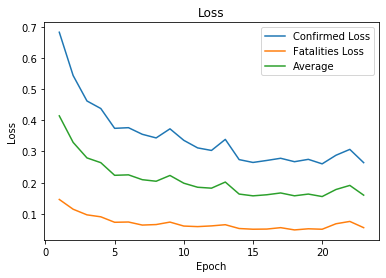

In [230]:
x = range(1,len(history.history["loss"])+1)

plt.plot(x, history.history["confirmed_loss"], label = "Confirmed Loss")
plt.plot(x, history.history["fatalities_loss"], label = "Fatalities Loss")
plt.plot(x, np.average([history.history["fatalities_loss"], history.history["confirmed_loss"]], axis=0), label = "Average")

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Loss')
plt.legend()
plt.show()

The training loss is plotted, the MSLE for sklearn takes the average of the 2 losses, thus that is added.

In [231]:
# Training Loss Average
np.average([history.history["confirmed_loss"][-1], history.history["fatalities_loss"][-1]])

0.16003145

In [232]:
model.evaluate(X_Test, get_y(Y_Test))

1470/1470 [==============================] - 0s 197us/sample - loss: 6.1515 - confirmed_loss: 4.5945 - fatalities_loss: 1.5616


[6.151500762887553, 4.5945015, 1.5615581]

In [353]:
predicted = model.predict(X_Test)

In [234]:
import math
fst = [math.ceil(val) for sublist in predicted[0] for val in sublist]
snd = [math.ceil(val) for sublist in predicted[1] for val in sublist]
mean_squared_log_error(Y_Test, list(zip(fst, snd)))

2.613023703035548

## Test different parameters and tune

In [81]:
from tensorflow.keras import optimizers

In [142]:
early_stopping_cb_cc = keras.callbacks.EarlyStopping(monitor="confirmed_loss",
                                                     patience=5, 
                                                      restore_best_weights=True)
early_stopping_cb_ft = keras.callbacks.EarlyStopping(monitor="fatalities_loss",
                                                         patience=5, 
                                                          restore_best_weights=True)
params = {
    "dropout":[0,0.2,0.5],
    "neurons":[500, 1000],
    "lr":[1, 0.1, 0.01],
    "activation":["exponential", "relu"]
}

In [143]:
def make_model(train, 
               dropout_threshold,
               neurons, 
               activation):

    input_layer_t = Input(shape=train.shape[1:],)
    d0_t = keras.layers.Dropout(dropout_threshold)(input_layer_t)
    n0_t = keras.layers.BatchNormalization()(d0_t)
    h0_t = Dense(neurons, activation='relu')(n0_t)

    d1_t = keras.layers.Dropout(dropout_threshold)(h0_t)
    n1_t = keras.layers.BatchNormalization()(d1_t)
    h1_t = Dense(neurons, activation='relu')(n1_t)

    d2_t = keras.layers.Dropout(dropout_threshold)(h1_t)
    n2_t = keras.layers.BatchNormalization()(d2_t)
    h2_t = Dense(neurons, activation='relu')(n2_t)

    d3_t = keras.layers.Dropout(dropout_threshold)(h2_t)
    n3_t = keras.layers.BatchNormalization()(d3_t)

    out1_t = Dense(1,  activation=activation, name="confirmed")(n3_t)
    out2_t = Dense(1,  activation=activation, name="fatalities")(n3_t)
    
    new_model = Model(inputs=input_layer_t, outputs=[out1_t,out2_t])
 

    return new_model

In [151]:
def compile_and_run(n_model, x_train, y_train, lr, verbose, epochs):
    opt = optimizers.SGD(learning_rate=lr) 
    new_model.compile(loss="mean_squared_logarithmic_error", optimizer="sgd")
  
    history = new_model.fit(x_train, get_y(y_train), 
          epochs=epochs, 
          callbacks=[early_stopping_cb_cc, early_stopping_cb_ft],
          verbose=verbose)
    return history

In [156]:
combination = []
for dropout in params["dropout"]:
    for neurons in params["neurons"]:
        for learning_rate in params["lr"]:
            for activation in params["activation"]:
                new_model = make_model(X_Train, dropout, neurons, activation)
                history = compile_and_run(new_model,
                                                X_Train, 
                                                Y_Train, 
                                                learning_rate, 
                                                verbose=0, 
                                                epochs=50)

                prediction = new_model.predict(X_Test)
                training_loss = np.average([history.history["confirmed_loss"][-1], 
                            history.history["fatalities_loss"][-1]])
                c_loss = [math.ceil(val) for sublist in prediction[0] for val in sublist]
                f_loss = [math.ceil(val) for sublist in prediction[1] for val in sublist]
                test_loss = mean_squared_log_error(Y_Test, list(zip(c_loss, f_loss)))

                combination.append(({
                                        "dropout":dropout,
                                        "neurons":neurons,
                                        "lr":learning_rate,
                                        "activation": activation
                                    },
                                    training_loss,
                                    test_loss,
                                    new_model, 
                                    history))

In [348]:
combination

[({'dropout': 0, 'neurons': 500, 'lr': 1, 'activation': 'exponential'},
  0.148827,
  2.6857504968238883,
  <tensorflow.python.keras.callbacks.History at 0x1539f51d0>),
 ({'dropout': 0, 'neurons': 500, 'lr': 1, 'activation': 'relu'},
  0.39669904,
  2.3280346311495506,
  <tensorflow.python.keras.callbacks.History at 0x1514f85d0>),
 ({'dropout': 0, 'neurons': 500, 'lr': 0.1, 'activation': 'exponential'},
  0.15603407,
  4.478487451393448,
  <tensorflow.python.keras.callbacks.History at 0x15435c650>),
 ({'dropout': 0, 'neurons': 500, 'lr': 0.1, 'activation': 'relu'},
  0.33165327,
  1.8976028987467588,
  <tensorflow.python.keras.callbacks.History at 0x14b0f72d0>),
 ({'dropout': 0, 'neurons': 500, 'lr': 0.01, 'activation': 'exponential'},
  0.14215438,
  2.773533011563312,
  <tensorflow.python.keras.callbacks.History at 0x156b15150>),
 ({'dropout': 0, 'neurons': 500, 'lr': 0.01, 'activation': 'relu'},
  0.33366477,
  1.7367189065531554,
  <tensorflow.python.keras.callbacks.History at 0x15

In [184]:
sortedlist = sorted(combination, key=lambda x:  x[1] + x[2])

In [185]:
selected = sortedlist[0]
selected

({'dropout': 0, 'neurons': 1000, 'lr': 0.1, 'activation': 'relu'},
 0.31514913,
 1.6812765645875276,
 <tensorflow.python.keras.callbacks.History at 0x1529de590>)

In [216]:
best_model = selected[3]

## Predicting

In [221]:
final_predictions = best_model.predict(prediction_final)

[array([[ 82.19774],
        [ 88.32913],
        [ 95.00081],
        ...,
        [196.16388],
        [210.51317],
        [226.84515]], dtype=float32),
 array([[0.      ],
        [0.      ],
        [0.      ],
        ...,
        [6.436579],
        [7.442737],
        [8.478667]], dtype=float32)]

In [222]:
confirmed_cases = [math.ceil(val) for sublist in final_predictions[0] for val in sublist]
fatalities = [math.ceil(val) for sublist in final_predictions[1] for val in sublist]

In [225]:
output_dataframe = pd.DataFrame(data={"ForecastId": forecast_ids, "ConfirmedCases": confirmed_cases, "Fatalities": fatalities})

In [226]:
output_dataframe.to_csv("submission.csv", index=False)